## Importing essential libraries

In [12]:
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

from tatva import Mesh, Operator, element, sparse


from jax_autovmap import autovmap
from functools import partial

import matplotlib.pyplot as plt

## Model setup

### Create mesh

In [13]:
import gmsh
import meshio


def get_elements_on_curve(mesh, curve_func, tol=1e-3):
    coords = mesh.coords
    elements_2d = mesh.elements
    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return jnp.array([], dtype=int)

    return jnp.array(elements_1d)


def generate_half_circle_mesh(
    radius: float = 1.0,
    mesh_size_fine: float = 0.4,
    mesh_size_coarse: float = 0.4,
    distance_from_rigid_plane: float = 1e-3,
):
    import os

    mesh_dir = os.path.join(os.getcwd(), "meshes")
    os.makedirs(mesh_dir, exist_ok=True)
    output_filename = os.path.join(mesh_dir, "half_circle.msh")

    # Parameters
    R = radius  # Radius of the half-circle

    gmsh.initialize()
    gmsh.model.add("half_circle")

    # Create points
    p1 = gmsh.model.geo.addPoint(0, R + distance_from_rigid_plane, 0)  # Center
    p2 = gmsh.model.geo.addPoint(-R, R + distance_from_rigid_plane, 0)  # Left point
    p3 = gmsh.model.geo.addPoint(R, R + distance_from_rigid_plane, 0)
    p4 = gmsh.model.geo.addPoint(0, distance_from_rigid_plane, 0)  # Center

    # Create the arc (half-circle)
    arc = gmsh.model.geo.addCircleArc(p2, p1, p4)
    arc_2 = gmsh.model.geo.addCircleArc(p4, p1, p3)

    # Create the flat line to close the half-circle
    line = gmsh.model.geo.addLine(p3, p1)
    line_2 = gmsh.model.geo.addLine(p1, p2)

    # Create a line loop and surface
    loop = gmsh.model.geo.addCurveLoop([arc, arc_2, line, line_2])
    surface = gmsh.model.geo.addPlaneSurface([loop])

    # Synchronize and mesh
    gmsh.model.geo.synchronize()

    # Create a Distance field to control mesh size near p_mid
    field_id = gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(field_id, "NodesList", [p4])

    # Create a Threshold field to refine near p_mid and coarsen further away
    thresh_field = gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(thresh_field, "InField", field_id)
    gmsh.model.mesh.field.setNumber(thresh_field, "SizeMin", mesh_size_fine)
    gmsh.model.mesh.field.setNumber(thresh_field, "SizeMax", mesh_size_coarse)
    gmsh.model.mesh.field.setNumber(thresh_field, "DistMin", R / 8)
    gmsh.model.mesh.field.setNumber(thresh_field, "DistMax", R / 4)

    # Set it as background mesh size field
    gmsh.model.mesh.field.setAsBackgroundMesh(thresh_field)

    # Generate the mesh
    gmsh.model.mesh.generate(2)
    gmsh.write(output_filename)
    print(f"Mesh successfully generated and saved to '{output_filename}'")

    gmsh.finalize()

    _mesh = meshio.read(output_filename)

    mesh = Mesh(
        coords=_mesh.points[:, :2],
        elements=_mesh.cells_dict["triangle"],
    )

    contact_elements = get_elements_on_curve(mesh, contact_line, tol=1e-6)

    return mesh, contact_elements


# get contact elements
# function identifies nodes on the line
def contact_line(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.isclose(
        jnp.linalg.norm(coord - jnp.array([0, radius + distance_from_rigid_plane])),
        radius,
        atol=1e-10,
    )


radius = 1.0
distance_from_rigid_plane = 1e-6

In [14]:
mesh_params = {
    "radius": radius,
    "mesh_size_fine": 0.02,
    "mesh_size_coarse": 0.05,
    "distance_from_rigid_plane": distance_from_rigid_plane,
}

mesh, contact_elements = generate_half_circle_mesh(**mesh_params)


contact_nodes = jnp.unique(contact_elements.flatten())
n_contact_nodes = len(contact_nodes)


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00208237s, CPU 0.002181s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0207078s, CPU 0.020549s)
Info    : 1012 nodes 2026 elements
Info    : Writing '/home/dab/moria/tatva/docs/examples/meshes/half_circle.msh'...
Mesh successfully generated and saved to '/home/dab/moria/tatva/docs/examples/meshes/half_circle.msh'
Info    : Done writing '/home/dab/moria/tatva/docs/examples/meshes/half_circle.msh'



### Plot the mesh

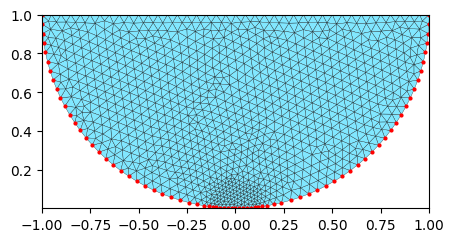

In [15]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.2,
    cmap="managua_r",
)
ax.scatter(
    mesh.coords[contact_nodes, 0], mesh.coords[contact_nodes, 1], color="red", s=4
)
ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()

## Defining material parameters

In [16]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the linear elastic material"""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


E = 1.0
nu = 0.3
mu = E / (2 * (1 + nu))
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))


mat = Material(mu=mu, lmbda=lmbda)

## Energy Definitions

### Defining total elastic energy

In [17]:
tri = element.Tri3()
op = Operator(mesh, tri)


@autovmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@autovmap(eps=2)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@autovmap(grad_u=2)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sig, eps)


@jax.jit
def total_strain_energy(u_flat: Array) -> float:
    """Compute the total energy of the system."""
    u = u_flat.reshape(-1, n_dofs_per_node)
    grad_u = op.grad(u)
    energy_density = strain_energy(grad_u, mat.mu, mat.lmbda)
    return op.integrate(energy_density)


### Defining the contact energy

In [18]:
k_pen = 1e6

line_mesh = Mesh(mesh.coords, contact_elements)
line2 = element.Line2()
line_op = Operator(line_mesh, line2)


@jax.jit
def total_area(u_flat: Array) -> float:
    u = u_flat.reshape(-1, 1)
    u_quad = line_op.eval(u)
    return jnp.sum(line_op.integrate(u_quad))


ones = jnp.ones(n_nodes)
nodes_area = jax.jacrev(total_area)(ones)


@jax.jit
def macaulay_bracket(x):
    return jnp.where(x > 0, 0, x)


@jax.jit
def compute_contact_energy(
    u: Array, coords: Array, contact_nodes: Array, nodes_area: Array
) -> Array:
    """Compute the contact energy for a given displacement field.
    Args:
        u: Displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
        nodes_area: Area of the nodes on the contact surface.
    Returns:
        Contact energy.
    """
    u_nodes = u[contact_nodes]
    x_nodes = coords[contact_nodes]
    contact_nodes_area = nodes_area[contact_nodes]

    # Loop over nodes on the potential contact surface
    def _contact_energy_node(
        u_node: tuple[float, float], x_node: tuple[float, float], contact_area: float
    ) -> float:
        gap = (x_node[1] + u_node[1]) - 0.0
        penetration = macaulay_bracket(gap)
        return 0.5 * k_pen * (penetration**2) * contact_area

    contact_energy_node = jax.vmap(_contact_energy_node, in_axes=(0, 0, 0))

    return jnp.sum(contact_energy_node(u_nodes, x_nodes, contact_nodes_area))

### Defining the total energy

In [19]:
@jax.jit
def _total_energy(
    u_flat: Array,
    coords: Array,
    contact_nodes: Array,
    nodes_area: Array,
) -> Array:
    """Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
        nodes_area: Area associated with all the nodes in the mesh
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    contact_energy = compute_contact_energy(u, coords, contact_nodes, nodes_area)
    strain_energy = total_strain_energy(u)
    return contact_energy + strain_energy


total_energy = partial(
    _total_energy,
    coords=mesh.coords,
    contact_nodes=contact_nodes,
    nodes_area=nodes_area,
)

## Computing the internal forces and the stiffness matrix

In [20]:
sparsity_pattern = sparse.create_sparsity_pattern(
    mesh, n_dofs_per_node=n_dofs_per_node
)

gradient = jax.jacrev(total_energy)
hessian_sparse = sparse.jacfwd(gradient, sparsity_pattern=sparsity_pattern)

## Applying Dirichlet boundary conditions

In [21]:
y_max = jnp.max(mesh.coords[:, 1])

top_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
fixed_dofs = jnp.concatenate([2 * top_nodes + 1])
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

prescribed_values = jnp.zeros(n_dofs)
prescribed_values = prescribed_values.at[2 * top_nodes + 1].set(-radius / 500)

zero_indices, one_indices = sparse.get_bc_indices(sparsity_pattern, fixed_dofs)

## Solving the Problem

In [22]:
import scipy.sparse as sp


def newton_scipy_solver(
    u,
    fext,
    gradient,
    hessian_sparse,
    fixed_dofs,
    zero_indices,
    one_indices,
):
    fint = gradient(u)

    iiter = 0
    norm_res = 1.0

    tol = 1e-8
    max_iter = 10

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0.0)

        K_sparse = hessian_sparse(u)
        K_data_lifted = K_sparse.data.at[zero_indices].set(0)
        K_data_lifted = K_data_lifted.at[one_indices].set(1)

        K_csr = sp.csr_matrix(
            (K_data_lifted, (K_sparse.indices[:, 0], K_sparse.indices[:, 1]))
        )

        du = sp.linalg.spsolve(K_csr, residual)
        u = u.at[:].add(du)

        fint = gradient(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)

        print(f"  Residual: {norm_res:.2e}")

        iiter += 1

    return u, norm_res


u_prev = jnp.zeros(n_dofs)
fext = jnp.zeros(n_dofs)

n_steps = 10

applied_displacement = prescribed_values / n_steps  # displacement increment

u_per_step = []
for step in range(n_steps):
    print(f"Step {step + 1}/{n_steps}")
    u_prev = u_prev.at[fixed_dofs].add(applied_displacement[fixed_dofs])

    u_new, rnorm = newton_scipy_solver(
        u_prev,
        fext,
        gradient,
        hessian_sparse,
        fixed_dofs,
        zero_indices,
        one_indices,
    )

    u_prev = u_new
    u_per_step.append(u_prev.reshape(n_nodes, n_dofs_per_node))

u_solution = u_prev.reshape(n_nodes, n_dofs_per_node)

Step 1/10
  Residual: 3.93e+00
  Residual: 8.69e-05
  Residual: 1.72e-18
Step 2/10
  Residual: 5.35e-18
Step 3/10
  Residual: 2.17e-01
  Residual: 9.47e-17
Step 4/10
  Residual: 3.09e-16
Step 5/10
  Residual: 2.49e-16
Step 6/10
  Residual: 2.22e-16
Step 7/10
  Residual: 1.39e-16
Step 8/10
  Residual: 1.16e-16
Step 9/10
  Residual: 2.56e-16
Step 10/10
  Residual: 2.59e-16


## Visualizing the stress field

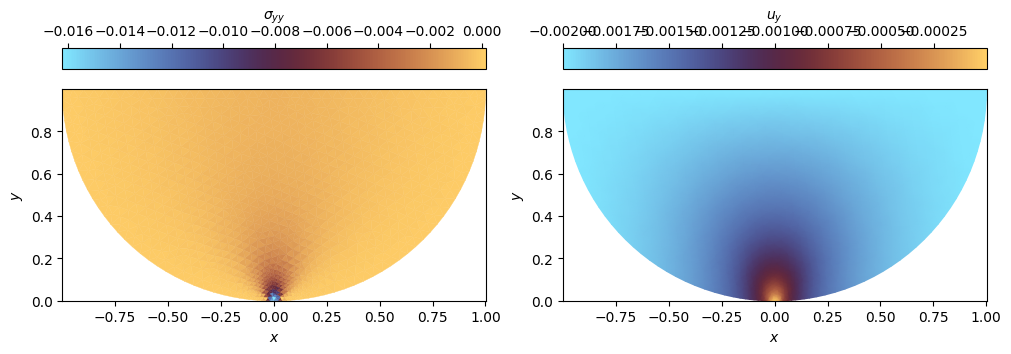

In [23]:
from tatva.plotting import plot_element_values, plot_nodal_values

# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)


fig, axs = plt.subplots(1, 2, figsize=(10, 6), layout="constrained")

plot_element_values(
    mesh.coords,
    mesh.elements,
    stresses[:, 1, 1].flatten(),
    u=u_solution,
    ax=axs[0],
    label=r"$\sigma_{yy}$",
)

axs[0].axhline(y=0, color="black", linewidth=0.5)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
axs[0].set_aspect("equal")
axs[0].margins(0.0, 0.0)

plot_nodal_values(
    mesh.coords,
    mesh.elements,
    u_solution[:, 1].flatten(),
    u=u_solution,
    ax=axs[1],
    label=r"$u_y$",
)

axs[1].axhline(y=0, color="black", linewidth=0.5)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
axs[1].set_aspect("equal")
axs[1].margins(0.0, 0.0)

plt.show()